In [1]:
import json
import os, sys
sys.path.append(os.getcwd())

from basenji import dataset, dna_io, seqnn

2024-10-11 15:43:02.888579: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-11 15:43:02.915305: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-11 15:43:02.915331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-11 15:43:02.916056: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-11 15:43:02.921294: I tensorflow/core/platform/cpu_feature_guar

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_dir = "./train_data/cell_type_specific/"

In [3]:
model_dir = "./"

In [4]:
params_file = model_dir+'params.json' # architecture
with open(params_file, 'r') as file:
    params = json.load(file)
    model_architecture = params['model']
seqnn_model = seqnn.SeqNN(model_architecture)
seqnn_model.model.summary()

2024-10-11 15:43:08.507285: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43626 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 32768, 4)]           0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 32768, 4),           0         ['sequence[0][0]']            
 ent (StochasticReverseComp   ())                                                                 
 lement)                                                                                          
                                                                                                  
 stochastic_shift (Stochast  (None, 32768, 4)             0         ['stochastic_reverse_complemen
 icShift)                                                           t[0][0]']               

In [ ]:
# python train.py -k -o ./train_out/ ./params.json .

In [5]:
data_stats_file = './statistics.json'
with open(data_stats_file) as data_stats_open:
    data_stats = json.load(data_stats_open)

In [6]:
hic_diags =  data_stats['diagonal_offset']
target_crop = data_stats['crop_bp'] // data_stats['pool_width']
target_length1 = data_stats['seq_length'] // data_stats['pool_width']
target_length1_cropped = target_length1 - 2*target_crop

In [ ]:
target_length1_cropped

In [7]:
split_label='train'

In [8]:
train_data = dataset.SeqDataset(data_dir="./", split_label=split_label, batch_size=8)
train_inputs, train_targets = train_data.numpy(return_inputs=True, return_outputs=True)

In [9]:
train_index = 0
train_target = train_targets[train_index:train_index+1,:,:]
train_target2 = train_targets[train_index+1:train_index+2,:,:]
train_target3 = train_targets[train_index+2:train_index+3,:,:]

In [10]:
train_target.shape

(1, 1953, 2)

In [13]:
import numpy as np
from cooltools.lib.numutils import set_diag

def from_upper_triu(vector_repr, matrix_len, num_diags):
    z = np.zeros((matrix_len,matrix_len))
    triu_tup = np.triu_indices(matrix_len,num_diags)
    z[triu_tup] = vector_repr
    for i in range(-num_diags+1,num_diags):
        set_diag(z, np.nan, i)
    return z + z.T

/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:652: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_correction_symmetric(
/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:727: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_co

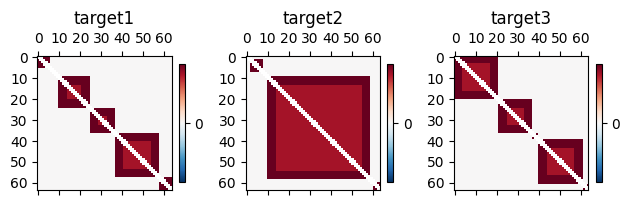

In [14]:
# plot target 
vmin=-0.6; vmax=0.6
plt.subplot(131) 
mat = from_upper_triu(train_target[:,:,0], target_length1_cropped, hic_diags)
im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
plt.title('target1')

plt.subplot(132) 
mat = from_upper_triu(train_target2[:,:,0], target_length1_cropped, hic_diags)
im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
plt.title('target2')

plt.subplot(133) 
mat = from_upper_triu(train_target3[:,:,0], target_length1_cropped, hic_diags)
im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
plt.title('target3')

plt.tight_layout()

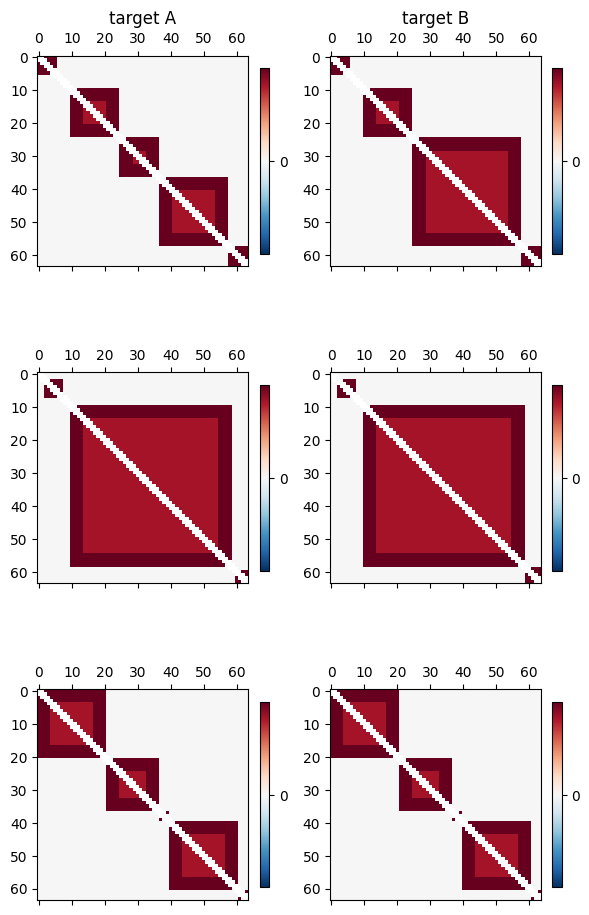

In [40]:
# plot target 
vmin=-0.6; vmax=0.6

plt.figure(figsize=(6,10))

plt.subplot(321) 
mat = from_upper_triu(train_target[:,:,0], target_length1_cropped, hic_diags)
im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2])
plt.title('target A')

plt.subplot(322) 
mat = from_upper_triu(train_target[:,:,1], target_length1_cropped, hic_diags)
im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2])
plt.title('target B')

plt.subplot(323) 
mat = from_upper_triu(train_target2[:,:,0], target_length1_cropped, hic_diags)
im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2])

plt.subplot(324) 
mat = from_upper_triu(train_target2[:,:,1], target_length1_cropped, hic_diags)
im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2])

plt.subplot(325) 
mat = from_upper_triu(train_target3[:,:,0], target_length1_cropped, hic_diags)
im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2])

plt.subplot(326) 
mat = from_upper_triu(train_target3[:,:,1], target_length1_cropped, hic_diags)
im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2])

plt.tight_layout()

In [15]:
# specify model parameters json to have only two targets
params_file = './params.json' # architecture
with open(params_file) as params_open:
    params = json.load(params_open)
    model_arch = params['model'] # Retrieve model's architecture from params.json

In [16]:
restore_weights = True

In [17]:
human_model = seqnn.SeqNN(model_arch)

if restore_weights:
    weights_file  = './train_out/model_best.h5' # model_weights
    human_model.restore(weights_file)

In [22]:
train_inputs.shape

(400, 32768, 4)

In [27]:
pred_from_seq = human_model.model.predict(train_inputs[0:1,:,:])
pred_from_seq2 = human_model.model.predict(train_inputs[1:2,:,:])
pred_from_seq3 = human_model.model.predict(train_inputs[2:3,:,:])

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


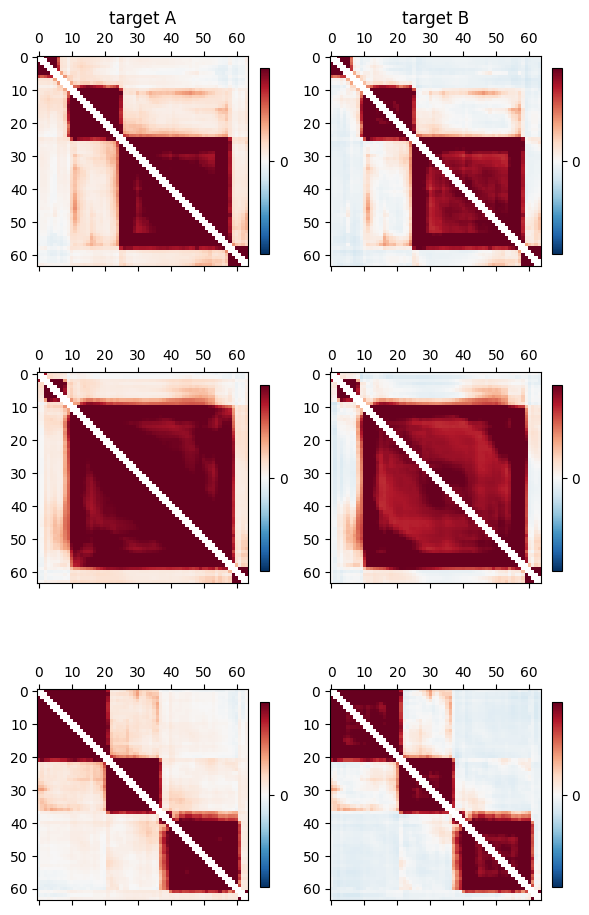

In [41]:

# plot target 
vmin=-0.6; vmax=0.6

plt.figure(figsize=(6,10))

plt.subplot(321) 
mat = from_upper_triu(pred_from_seq[:,:,0], target_length1_cropped, hic_diags)
im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2])
plt.title('target A')

plt.subplot(322) 
mat = from_upper_triu(pred_from_seq[:,:,1], target_length1_cropped, hic_diags)
im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2])
plt.title('target B')

plt.subplot(323) 
mat = from_upper_triu(pred_from_seq2[:,:,0], target_length1_cropped, hic_diags)
im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2])

plt.subplot(324) 
mat = from_upper_triu(pred_from_seq2[:,:,1], target_length1_cropped, hic_diags)
im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2])

plt.subplot(325) 
mat = from_upper_triu(pred_from_seq3[:,:,0], target_length1_cropped, hic_diags)
im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2])

plt.subplot(326) 
mat = from_upper_triu(pred_from_seq3[:,:,1], target_length1_cropped, hic_diags)
im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2])

plt.tight_layout()

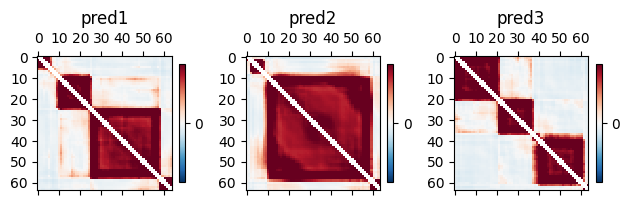

In [29]:
vmin=-0.6; vmax=0.6

# plot pred
plt.subplot(131) 
mat = from_upper_triu(pred_from_seq[:,:,1], target_length1_cropped, hic_diags)
im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
plt.title('pred1')

plt.subplot(132) 
mat = from_upper_triu(pred_from_seq2[:,:,1], target_length1_cropped, hic_diags)
im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
plt.title('pred2')

plt.subplot(133) 
mat = from_upper_triu(pred_from_seq3[:,:,1], target_length1_cropped, hic_diags)
im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
plt.title('pred3')

plt.tight_layout()

In [30]:
import h5py

In [31]:
file_path = "./train_out/model_check.h5" 

In [32]:
with h5py.File(file_path, 'r') as h5_file:
    for key in h5_file:
        print(key)

model_weights
optimizer_weights
